In [383]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
import warnings
warnings.simplefilter("ignore")

- [The Catalog site](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermilgrb&Action=More+Options)
- [Feature key](https://heasarc.gsfc.nasa.gov/W3Browse/fermi/fermilgrb.html)

Only enforced parameter at query-level is that redshift "=null"


You can check a burst's GBM signatures by putting its name into the [GRB burst catalog](https://heasarc.gsfc.nasa.gov/db-perl/W3Browse/w3table.pl?tablehead=name%3Dfermigbrst&Action=More+Options) and selecting the data products option "D".

In [384]:
dat = Table.read('Query090822.fits')
targets = dat.to_pandas()

# Remove trailing whitespace
targets = targets.rename(columns=lambda x: x.strip().lower())

targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Columns: 107 entries, name to gbm_cat_fluence_error
dtypes: float64(101), int16(2), object(4)
memory usage: 153.4+ KB


In [385]:
# Apply the flux_ratio calculations
targets['flux_ratio'] = targets['like_gbm_flux']/targets['like_lat_flux']
targets['flux_ene_ratio'] = targets['like_gbm_flux_ene']/targets['like_lat_flux_ene']
targets['fluence_ratio'] = targets['like_gbm_fluence']/targets['like_lat_fluence']

def propagate_error(a, b, e_a, e_b):
    return np.abs(a/b) * np.sqrt( (e_a/a)**2 + (e_b/b) )

targets['flux_ratio_error'] = propagate_error(targets['like_gbm_flux'],
                                              targets['like_lat_flux'],
                                              targets['like_gbm_flux_error'],
                                              targets['like_lat_flux_error'])

targets['flux_ene_ratio_error'] = propagate_error(targets['like_gbm_flux_ene'],
                                                  targets['like_lat_flux_ene'],
                                                  targets['like_gbm_flux_ene_error'],
                                                  targets['like_lat_flux_ene_error'])

targets['fluence_ratio_error'] = propagate_error(targets['like_gbm_fluence'],
                                                  targets['like_lat_fluence'],
                                                  targets['like_gbm_fluence_error'],
                                                  targets['like_lat_fluence_error'])

# Generate time difference calculation
targets['gbm-lat_time_difference'] = targets['like_gbm_t0'] - targets['like_lat_t0']

targets.T.tail(5).T.describe()

,fluence_ratio,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,gbm-lat_time_difference
count,179.0,128.0,128.0,128.0,186.0
unique,130.0,115.0,115.0,115.0,178.0
top,0.0,0.0,0.0,0.0,0.0
freq,43.0,14.0,14.0,14.0,7.0


The original method simply extracted all sources with a gbm-lat_time_difference > 0.

In [386]:
original_targets = targets[ targets['gbm-lat_time_difference'] > 0 ]

original_targets

,name,gcn_name,time,trigger_met,ra,dec,lii,bii,error_radius,redshift,...,gbm_cat_t95,gbm_cat_fluence,gbm_cat_fluence_error,flux_ratio,flux_ene_ratio,fluence_ratio,flux_ratio_error,flux_ene_ratio_error,fluence_ratio_error,gbm-lat_time_difference
1,b'GRB190731943 ',b'GRB190731A ',58695.943322,5.863055e+08,340.31,-76.42,312.1918,-38.2711,0.31,0.0,...,17.664,0.000089,3.384800e-08,4.471796,1.431112,0.082395,2.782806,1.239458,0.071361,1.732
7,b'GRB150902733 ',b'GRB150902A ',57267.733090,4.629081e+08,214.95,-69.38,310.6147,-7.8370,0.18,0.0,...,17.408,0.000083,5.199900e-08,15.192490,7.990990,0.267589,7.153756,4.975208,0.166602,0.350
19,b'GRB091031500 ',b'GRB91031.0 ',55135.500324,2.786832e+08,71.81,-57.73,266.8182,-39.0972,0.23,0.0,...,35.329,0.000015,8.647700e-08,5.362551,2.258883,0.187747,3.078137,1.912598,0.158966,1.348
48,b'GRB150118409 ',b'GRB150118B ',57040.408530,4.432673e+08,240.23,-35.93,340.5789,12.7382,0.56,0.0,...,47.873,0.000141,1.097200e-07,1.029882,1.029886,0.886573,0.000000,0.000000,0.000000,3.340
49,b'GRB131216081 ',b'GRB131216A ',56642.080926,4.088518e+08,91.59,-35.50,242.0253,-23.9780,2.24,0.0,...,19.265,0.000007,3.990000e-08,inf,inf,inf,NaN,NaN,NaN,0.003
51,b'GRB121225417 ',b'GRB121225B ',56286.417280,3.781225e+08,310.45,-34.83,8.2097,-36.7829,1.50,0.0,...,67.969,0.000070,1.911000e-07,inf,inf,inf,NaN,NaN,NaN,9.472
56,b'GRB180718763 ',b'GRB180718B ',58317.762778,5.536307e+08,44.48,-30.33,227.1050,-62.1772,0.95,0.0,...,99.906,0.000015,4.955800e-08,0.221914,0.246738,1.607397,0.152221,0.211042,1.374860,0.530
87,b'GRB140206275 ',b'GRB140206B ',56694.275139,4.133614e+08,315.24,-8.79,40.1247,-32.7317,0.08,0.0,...,154.178,0.000123,2.782200e-07,14.338529,5.772216,0.098635,6.008167,3.477275,0.059419,6.878
155,b'GRB160821857 ',b'GRB160821A ',57621.857292,4.935045e+08,171.29,42.29,166.5733,66.7930,0.12,0.0,...,161.539,0.000522,8.586400e-08,4.091682,2.120156,0.066702,1.663456,1.036846,0.032620,26.450
166,b'GRB150416773 ',b'GRB150416A ',57128.773206,4.509020e+08,58.75,52.96,148.5600,-0.5255,1.93,0.0,...,33.792,0.000006,5.901600e-08,inf,inf,inf,NaN,NaN,NaN,0.512


There should be a negative correlation between burst duration and corresponding fluence ratio (0927-6505(96)00018-7, Figure 2.)

(0.0, 1.0)

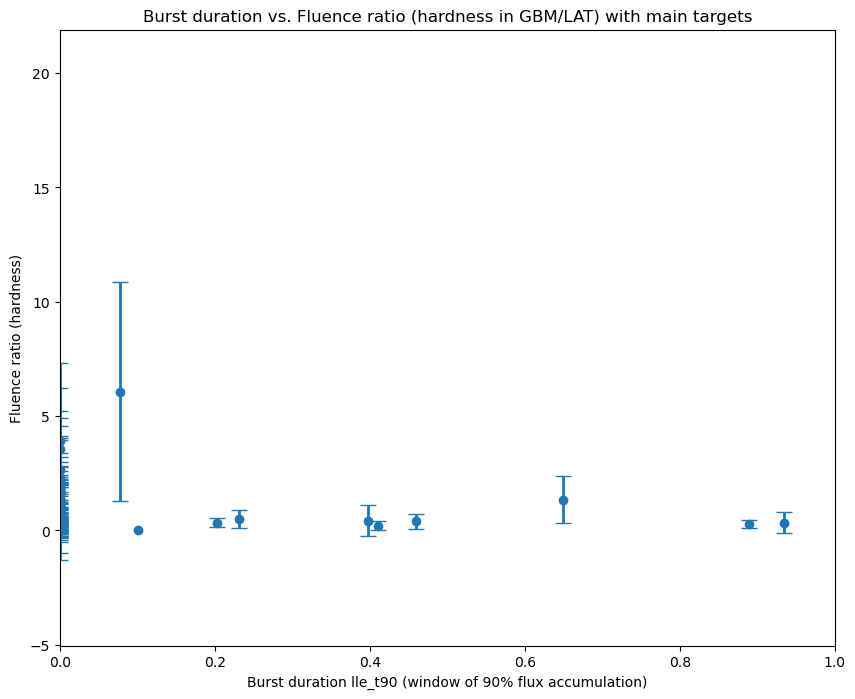

In [407]:
fig, ax = plt.subplots()
ax.errorbar(x = targets['lle_t90'], y=targets['fluence_ratio'], 
            yerr = targets['fluence_ratio_error'], fmt = 'o', linewidth = 2, capsize = 6)
ax.set_xlabel('Burst duration lle_t90 (window of 90% flux accumulation)')
ax.set_ylabel('Fluence ratio (hardness)')
fig.set_figwidth(10)
fig.set_figheight(8)
ax.set_title('Burst duration vs. Fluence ratio (hardness in GBM/LAT) with main targets')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(0,1)

Try to see if the considered correlation does exist by seeing if there's that negative correlation.

In [408]:
# Polyfit does not like NaNs or infs
print('Dropping %s targets for inf fluence_ratio'% len(targets.loc[targets['fluence_ratio'] == np.inf]) )
targets = targets.loc[ targets['fluence_ratio'] != np.inf ]
print('Dropping %s targets for NaN fluence_ratio'% len(targets.loc[ np.isnan(targets['fluence_ratio']) ]) )
targets = targets.loc[ ~np.isnan(targets['fluence_ratio']) ]

# These ones will have had a 0.0 in the LAT flux, causing a NaN
print('Dropping %s targets for NaN fluence_ratio_error'% len(targets.loc[ np.isnan(targets['flux_ratio_error']) ]) )
targets = targets.loc[ ~np.isnan(targets['fluence_ratio_error']) ]

# These ones will have had a 0.0 in GBM flux, causing a 0.
print('Dropping %s targets for 0. fluence_ratio_error'%len(targets[targets['flux_ratio_error'] ==0]))
targets = targets[targets['fluence_ratio_error'] !=0]

Dropping 8 targets for inf fluence_ratio
Dropping 7 targets for NaN fluence_ratio
Dropping 43 targets for NaN fluence_ratio_error
Dropping 14 targets for 0. fluence_ratio_error


Text(0.5, 0.01, 'Fluence ratio ~= hardness wrt. GBM and LAT -- GBM (10 keV - 25 MeV) / LAT (20 MeV - 300 MeV)')

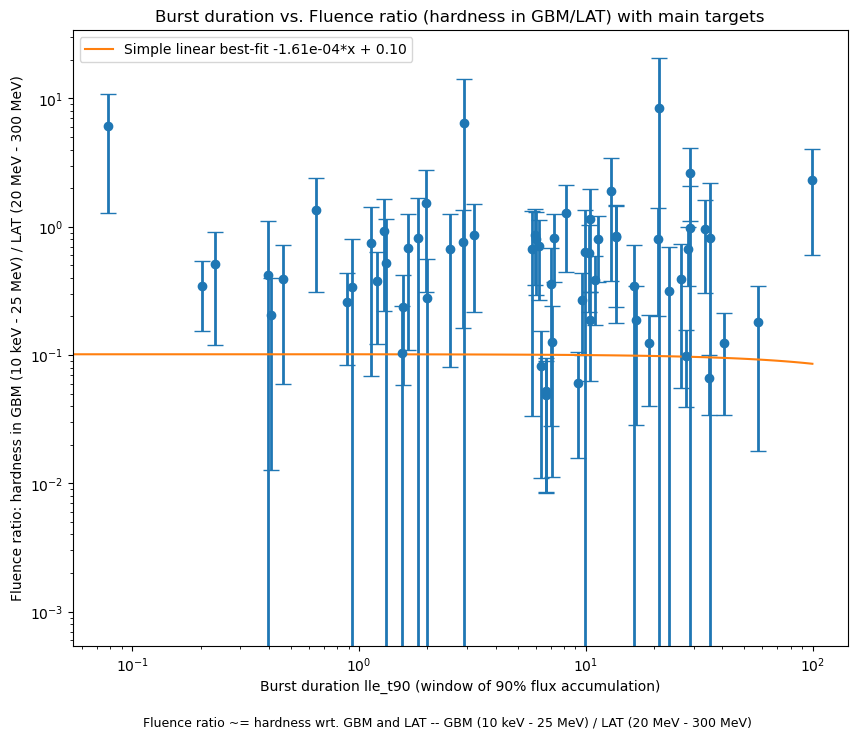

In [328]:
result = np.polyfit(x = targets['lle_t90'], y = targets['fluence_ratio'], 
                 deg = 1, w = 1/targets['fluence_ratio_error'], full=True)
fit = result[0]

fig, ax = plt.subplots()
ax.errorbar(x = targets['lle_t90'], y=targets['fluence_ratio'], 
            yerr = targets['fluence_ratio_error'], fmt = 'o', linewidth = 2, capsize = 6)
ax.set_xlabel('Burst duration lle_t90 (window of 90% flux accumulation)')
ax.set_ylabel('Fluence ratio: hardness in GBM (10 keV - 25 MeV) / LAT (20 MeV - 300 MeV)')
fig.set_figwidth(10)
fig.set_figheight(8)
ax.set_title('Burst duration vs. Fluence ratio (hardness in GBM/LAT) with main targets')
#ax.set_xscale('log')

stats = targets['lle_t90'].describe()

time_domain = np.linspace(stats['min'], stats['max'], 100)

ax.plot(time_domain, time_domain*fit[0] + fit[1] 
        , '-', label = 'Simple linear best-fit %.2e*x + %.2f'%(fit[0], fit[1]))
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

plt.figtext(0.5, 0.01, 
            'Fluence ratio ~= hardness wrt. GBM and LAT -- GBM (10 keV - 25 MeV) / LAT (20 MeV - 300 MeV)', 
            horizontalalignment='center', fontsize=9)

In [329]:
fig.savefig('Burst_duration_vs_hardness.png')

In [473]:
# Do we want the ones with the highest hardness value?
print('Sorted by hardness: ')
print(targets[['fluence_ratio', 'name', 'ra', 'dec', 'lle_t90']].sort_values(by='fluence_ratio', 
                                                                             ascending=False).head(20))
#targets.iloc[65]

# I want to get the smallest burst-duration one too
print('\nSorted by burst duration:')
print(targets[ targets['lle_t90']!=0.0 ][['lle_t90', 'name', 'ra', 'dec', 'fluence_ratio']].sort_values(
    by = 'lle_t90', ascending=True).head(20))
#targets.iloc[47] #0.71s source
#targets.iloc[77]
#targets.iloc[177]
#targets.iloc[98]
#targets.iloc[2]

Sorted by hardness: 
     fluence_ratio                 name      ra    dec  lle_t90
65        8.433630  b'GRB100826957    '  277.71 -25.27   21.087
144       6.426991  b'GRB180305393    '   49.67  32.10    2.894
77        6.069751  b'GRB130310840    '  142.38 -17.10    0.078
163       3.904246  b'GRB170306588    '  154.54  51.55    0.000
167       3.566120  b'GRB171102107    '  187.72  54.01    0.000
34        2.627453  b'GRB170906030    '  203.94 -47.12    0.000
162       2.604736  b'GRB120226871    '  302.97  48.98   28.926
183       2.306479  b'GRB100724029    '  123.59  75.86   99.807
142       2.289091  b'GRB161015710    '  269.13  30.16    0.000
184       2.113133  b'GRB141113346    '  182.32  77.38    0.000
156       1.982881  b'GRB111210359    '  122.51  44.09    0.000
161       1.894373  b'GRB190122305    '  258.71  48.12   12.911
78        1.811143  b'GRB101227406    '  240.21 -15.93    0.000
143       1.800486  b'GRB081102365    '  212.95  30.33    0.000
72        1.775366 

Time to focus a little on their angular distribution. Since the candidates aren't parsed down, the distribution won't mean too much. I'm curious, though, whether Cline's anomalous overdense region shows up.

Text(0.72, 0.01, 'In galactic lat. & long. coordinates, the galactic center is at (0,0) \nand the galactic plane is along the x-axis.')

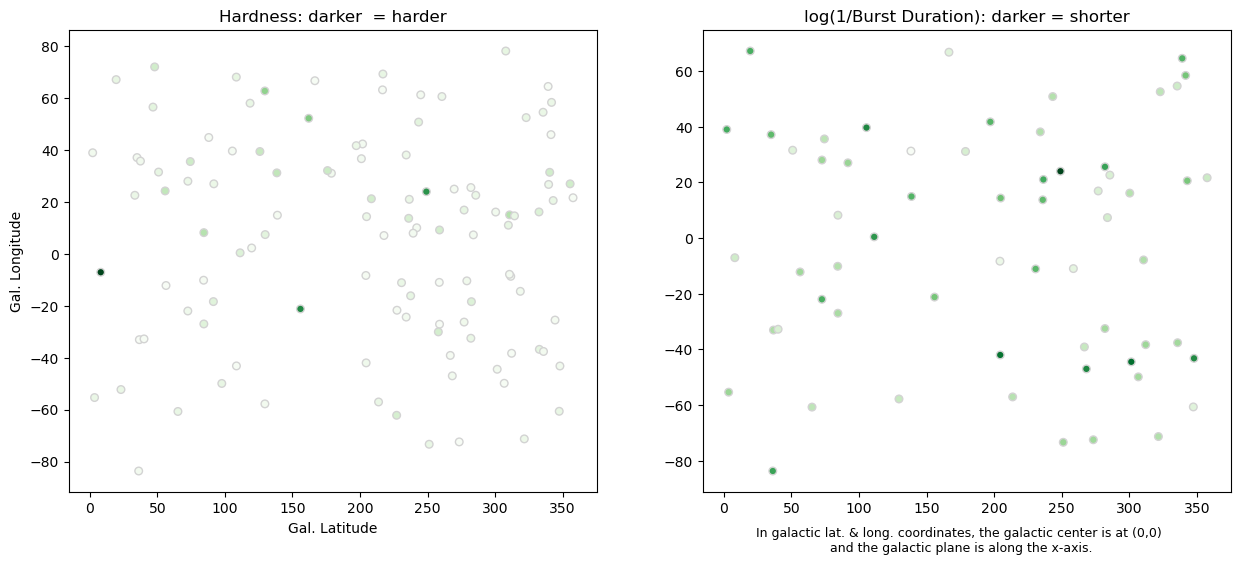

In [502]:
fig, (ax1,ax2) = plt.subplots(1,2)

fig.set_figwidth(15)
fig.set_figheight(6)

ax1.set_title('Hardness: darker  = harder')
ax1.scatter(targets['lii'], targets['bii'], 30, c=targets['fluence_ratio'], cmap='Greens', edgecolors='lightgray')

ax2.set_title('log(1/Burst Duration): darker = shorter')
ax2.scatter(targets['lii'], targets['bii'], 30, c=np.log10(1/targets['lle_t90']), cmap='Greens', edgecolors='lightgray')

ax1.set_ylabel('Gal. Longitude')
ax1.set_xlabel('Gal. Latitude')

plt.figtext(0.72, 0.01, 
            'In galactic lat. & long. coordinates, the galactic center is at (0,0) \nand the galactic plane is along the x-axis.', 
            horizontalalignment='center', fontsize=9)